In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import os
print(os.listdir("../input"))

['predict the news category']


In [2]:
from fastai.text import *
from fastai.imports import *
from fastai.text import *
from fastai import *

In [3]:
path = Path('../input/predict the news category/')
path.ls()

[PosixPath('../input/predict the news category/Sample_submission.xlsx'),
 PosixPath('../input/predict the news category/Data_Train.xlsx'),
 PosixPath('../input/predict the news category/Data_Test.xlsx')]

In [4]:
train = pd.read_excel(path/'Data_Train.xlsx')
test = pd.read_excel(path/'Data_Test.xlsx')
sub = pd.read_excel(path/'Sample_submission.xlsx')

/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [5]:
train.shape, test.shape, sub.shape

((7628, 2), (2748, 1), (2748, 1))

In [6]:
train.head(2)

,STORY,SECTION
0,But the most painful was the huge reversal in ...,3
1,How formidable is the opposition alliance amon...,0


In [7]:
test.head(2)

,STORY
0,2019 will see gadgets like gaming smartphones ...
1,It has also unleashed a wave of changes in the...


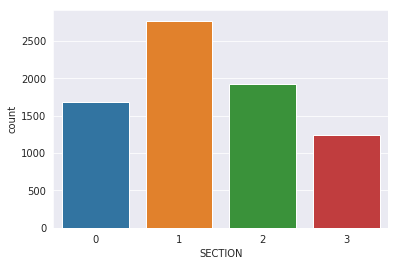

In [8]:
sns.countplot(x='SECTION', data=train)

In [9]:
def random_seed(seed_value):
    import random 
    random.seed(seed_value)  
    import numpy as np
    np.random.seed(seed_value)  
    import torch
    torch.manual_seed(seed_value)  
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)  
        torch.backends.cudnn.deterministic = True   
        torch.backends.cudnn.benchmark = False

In [10]:
from sklearn.metrics import accuracy_score 
y_pred_totcb = []
from sklearn.model_selection import KFold, RepeatedKFold
fold = KFold(n_splits=15, shuffle=True, random_state=0)
i=1

for train_index, test_index in fold.split(train):
    
    train_df = train.iloc[train_index]
    valid_df = train.iloc[test_index]

    random_seed(10)
    
    data_lm = TextLMDataBunch.from_df(Path(path), train_df, valid_df, test, text_cols=[0], bs=32)
    data_clas = TextClasDataBunch.from_df(Path(path), train_df, valid_df, test, text_cols=[0], label_cols=1, bs=32)
    
    learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.4, model_dir='/tmp/model/')
    learn.fit_one_cycle(1, 1e-2, moms=(0.8, 0.7))
    learn.unfreeze()
    learn.fit_one_cycle(9, 1e-3, moms=(0.8,0.7))
    learn.save_encoder('model_enc')
    
    learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.4, model_dir='/tmp/model/')
    learn.load_encoder('model_enc')
    learn.fit_one_cycle(1, 1e-2, moms=(0.8, 0.7))
    learn.freeze_to(-2)
    learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))
    learn.freeze_to(-3)
    learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))
    learn.unfreeze()
    learn.fit_one_cycle(5, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))
   
    log_preds, test_labels = learn.get_preds(ds_type=DatasetType.Test, ordered=True)
    preds = np.argmax(log_preds, 1)
    y_pred_totcb.append(preds)
    print(f'fold {i} completed')
    i = i+1

epoch,train_loss,valid_loss,accuracy,time
0,3.884861,3.618055,0.341282,00:33


epoch,train_loss,valid_loss,accuracy,time
0,3.383326,3.510152,0.353401,00:40
1,3.297758,3.433312,0.364023,00:40
2,3.114028,3.382402,0.373136,00:39
3,2.867497,3.353268,0.377482,00:40
4,2.580076,3.357384,0.382314,00:40
5,2.304793,3.380360,0.384887,00:40
6,2.100055,3.420664,0.385018,00:40
7,1.930216,3.454225,0.384191,00:40
8,1.888747,3.466512,0.384073,00:40


epoch,train_loss,valid_loss,accuracy,time
0,0.155208,0.100051,0.974460,00:15


epoch,train_loss,valid_loss,accuracy,time
0,0.137248,0.090150,0.968566,00:18


epoch,train_loss,valid_loss,accuracy,time


# Submission

In [11]:
df = pd.DataFrame()
for i in range(15):
    col_name = 'SECTION_' + str(i)
    df[col_name] =  y_pred_totcb[i] 

In [12]:
df.shape

(2748, 15)

In [13]:
df.tail()

,SECTION_0,SECTION_1,SECTION_2,SECTION_3,SECTION_4,SECTION_5,SECTION_6,SECTION_7,SECTION_8,SECTION_9,SECTION_10,SECTION_11,SECTION_12,SECTION_13,SECTION_14
2743,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2744,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2745,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2746,0,0,3,3,0,0,0,0,0,0,0,0,3,0,0
2747,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [14]:
sub = pd.DataFrame()
sub['SECTION'] = df.mode(axis=1)[0]
sub.tail()

,SECTION
2743,1
2744,1
2745,1
2746,0
2747,1


In [15]:
sub['SECTION'].value_counts()

1    1183
2     826
0     417
3     322
Name: SECTION, dtype: int64

In [16]:
from IPython.display import HTML
import pandas as pd
import numpy as np
import base64

def create_download_link(df, title = "Download CSV file", filename = "submission.csv"):  
    csv = df.to_csv(index=False)
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

create_download_link(sub)